# Volatility puzzle (forecast of stock returns with volatility) with regime switch

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load data

In [2]:
df_market_daily = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Stocks/CRSP stock returns/market_daily.dta')

df_market_daily.index = pd.PeriodIndex(df_market_daily['date'], freq='D')
df_market_daily = df_market_daily['vwretd'] * 100

df_std = df_market_daily.resample('M').std()
df_var = df_market_daily.resample('M').var()

df_volatility = pd.concat([df_std, df_var], axis=1)
df_volatility = df_volatility.dropna()
df_volatility.columns = ['std', 'var']

df_volatility.head()

,std,var
date,,
1926-01,0.587527,0.345188
1926-02,0.669466,0.448185
1926-03,1.515431,2.296532
1926-04,0.735433,0.540862
1926-05,0.557876,0.311226


In [3]:
df_ff3 = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Stocks/Fama_French/ff3factors_monthly.dta')
df_cape = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Stocks/predictors/Shiller.dta')

df_combined = df_ff3.merge(df_cape, on='date', how='inner')

df_combined.index = pd.PeriodIndex(df_combined['date'], freq='M')
df_combined = df_combined[['mktrf', 'cape']]

In [4]:
df_combined = df_combined.join(df_volatility, how='inner')
df_combined = sm.add_constant(df_combined)
df_combined.head(3)

,const,mktrf,cape,std,var
date,,,,,
1926-07,1.0,2.96,11.869694,0.448890,0.201502
1926-08,1.0,2.64,12.488808,0.590640,0.348856
1926-09,1.0,0.36,12.692615,0.491208,0.241285


## Simple OLS regressions

In [5]:
ols = sm.OLS(df_combined['mktrf'].shift(-1), df_combined[['const','std','mktrf','cape']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  mktrf   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.724
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           0.000170
Time:                        20:54:07   Log-Likelihood:                -3319.7
No. Observations:                1073   AIC:                             6647.
Df Residuals:                    1069   BIC:                             6667.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3978      0.504      2.775      0.0

In [6]:
ols = sm.OLS(df_combined['mktrf'].shift(-1), df_combined[['const','var','mktrf','cape']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  mktrf   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.546
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           0.000219
Time:                        20:54:07   Log-Likelihood:                -3320.0
No. Observations:                1073   AIC:                             6648.
Df Residuals:                    1069   BIC:                             6668.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5654      0.448      3.497      0.0

## Markov regime switch model: 2 regimes

                        Markov Switching Model Results                        
Dep. Variable:                  mktrf   No. Observations:                 1073
Model:               MarkovRegression   Log Likelihood               -3151.252
Date:                Tue, 14 Nov 2017   AIC                           6326.505
Time:                        20:54:08   BIC                           6386.243
Sample:                    07-31-1926   HQIC                          6349.132
                         - 11-30-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3396      0.501      0.677      0.498      -0.643       1.322
x1             2.0439      0.519      3.942      0.0

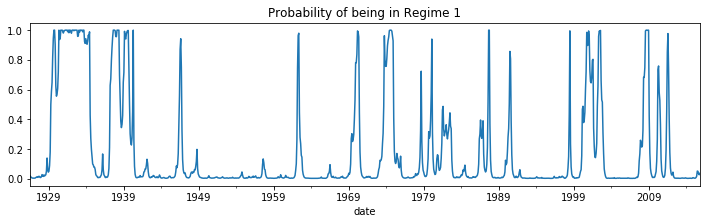

In [7]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['mktrf'].shift(-1),
    exog=df_combined[['std','mktrf','cape']],
    k_regimes=2, switching_variance=True, missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

                        Markov Switching Model Results                        
Dep. Variable:                  mktrf   No. Observations:                 1073
Model:               MarkovRegression   Log Likelihood               -3150.212
Date:                Tue, 14 Nov 2017   AIC                           6324.423
Time:                        20:54:10   BIC                           6384.162
Sample:                    07-31-1926   HQIC                          6347.051
                         - 11-30-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9029      0.400      2.258      0.024       0.119       1.686
x1             1.6533      0.146     11.300      0.0

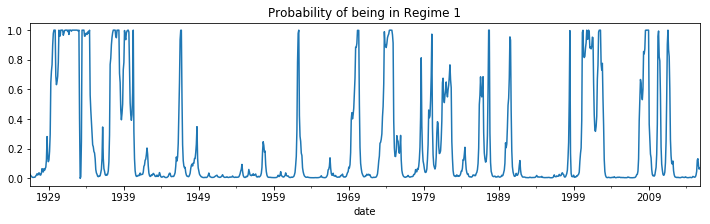

In [8]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['mktrf'].shift(-1),
    exog=df_combined[['var','mktrf','cape']],
    k_regimes=2, switching_variance=True, missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

## Markov regime switch model: 2 regimes, post-war sample

                        Markov Switching Model Results                        
Dep. Variable:                  mktrf   No. Observations:                  839
Model:               MarkovRegression   Log Likelihood               -2347.999
Date:                Tue, 14 Nov 2017   AIC                           4719.998
Time:                        20:54:11   BIC                           4776.785
Sample:                    01-31-1946   HQIC                          4741.764
                         - 11-30-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4530      0.503      2.889      0.004       0.467       2.439
x1             1.2980      0.197      6.600      0.0

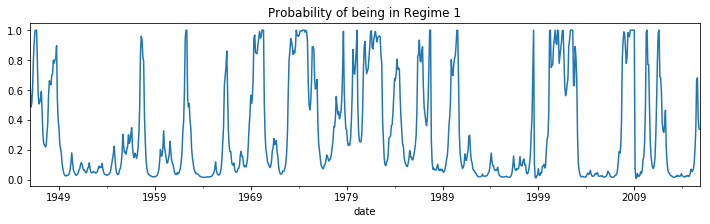

In [9]:
subsample = df_combined['1946-01':]

regime_model = sm.tsa.MarkovRegression(
    subsample['mktrf'].shift(-1),
    exog=subsample[['var','mktrf','cape']],
    k_regimes=2, switching_variance=True, missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));